In [76]:
from sklearn.model_selection import StratifiedKFold
import polars as pl

TARGET = 'column_11'

def fetch_data(df, use_split):
    assert(use_split >= 0 and use_split <= 4)
    # Perform 5-fold cross validation with a deterministic seed
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2028)
    split_x, split_y = get_x_y(df)
    splits = list(kf.split(split_x, split_y))
    # Indexing the dataframe with an array returns the appropriate splits
    df_train, df_test = df[splits[use_split][0]], df[splits[use_split][1]]
    mean = df_train.get_column("column_7").mean()
    df_train = df_train.with_columns("column_7").fill_null(mean)
    df_test = df_test.with_columns("column_7").fill_null(mean)
    return df_train, df_test

def get_x_y(df):
    X, y = df.drop(['column_1', TARGET]), df.get_column(TARGET) # we don't care about the ID column either
    return X.to_numpy(), y.to_numpy()

df = pl.read_csv('breast-cancer-wisconsin.data', has_header=False, null_values="?")
df_train, df_test = fetch_data(df, 0)
X_train, y_train = get_x_y(df_train)
X_test, y_test = get_x_y(df_test)
df_train.tail()
# df.head()
# df_train.get_column("column_7").unique()
(df_test.get_column(TARGET) == 2.0).sum() / len(df_test)

0.6571428571428571

In [62]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

model = make_pipeline(StandardScaler(), SVC(gamma='auto'))
model.fit(X_train, y_train)
model.score(X_test, y_test)


0.9714285714285714

In [88]:
from sklearn.metrics import balanced_accuracy_score

def svm(df, use_split):
    df_train, df_test = fetch_data(df, use_split)
    X_train, y_train = get_x_y(df_train)
    X_test, y_test = get_x_y(df_test)
    model = make_pipeline(StandardScaler(), SVC(gamma="auto", kernel="rbf", C=1.69)).fit(X_train, y_train)
    pred = model.predict(X_test)
    print(balanced_accuracy_score(y_test, pred))
    return model.score(X_test, y_test)

scores = [svm(df, x) for x in range(5)]
scores

0.9470108695652174
0.957427536231884
0.973731884057971
0.9780219780219781
0.9626831501831502


[0.95,
 0.9571428571428572,
 0.9785714285714285,
 0.9714285714285714,
 0.9640287769784173]

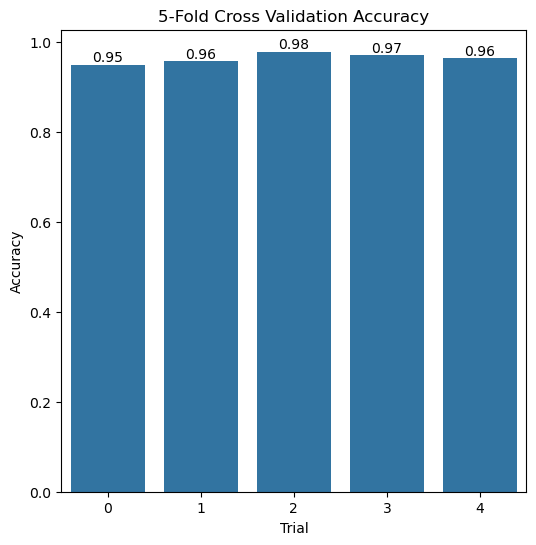

In [78]:
import matplotlib.pyplot as plt
import seaborn
import pandas as pd

f, ax = plt.subplots(1, figsize=(6, 6))
COLORS = seaborn.color_palette()

plot_df = pd.DataFrame.from_dict({'Accuracy': scores, 'Trial': list(range(5))})
ax.set_title('5-Fold Cross Validation Accuracy')
seaborn.barplot(data=plot_df, x='Trial', y='Accuracy', ax=ax, color=COLORS[0])
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f")